# Code 3. Graph Property

본 실슬에서는 그래프의 다양한 특성 중 그래프 지름, 전역 군집 계수, 차수 분포를 배우고 small world graph의 특징을 확인해봅니다.



In [5]:
import os
import sys

import collections

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize) # 배열 생략없이 전체 출력

import networkx as nx

In [6]:
cycle_graph = nx.Graph()
regular_graph = nx.Graph()
small_world_graph = nx.Graph()
random_graph = nx.Graph()

In [8]:
# 실습에 사용할 데이터 로드
print("###### Read Graphs ######")

graphs = [cycle_graph, regular_graph, small_world_graph, random_graph]
datas = ['cycle.txt', 'regular.txt', 'small_world.txt', 'random.txt']

for graph, data in zip(graphs, datas):
    
    PATH = os.path.join('graph', 'lab', 'lab2', data)
    f = open(PATH)
    for line in f:
        v1, v2 = map(int, line.split())
        graph.add_edge(v1, v2)

###### Read Graphs ######


#### 4) 군집 구조

군집은 정점들의 집합으로 다음의 조건을 만족합니다.

- 집합에 속하는 정점 사이에는 많은 간선이 존재함
- 집합에 속하는 정점과 그렇지 않은 정점 사이에는 적은 수의 간선이 존재함

**지역적 군집 계수(Local Clustering Coefficient)**

정점별로 군집의 형성 정도를 의미하는 지역적 군집 계수(Local Clustering Coefficient)를 정의할 수 있습니다. 정점 v의 지역적 군집 계수는 정점 v의 이웃 쌍 중 간선으로 연결된 쌍의 비율을 의미합니다.

첫번째 그래프의 경우, 정점 1과 연결된 이웃은 {2,3,4,5}입니다. 이웃의 쌍은 (2,3), (3,4), (4,5), (2,4), (2,5), (3,5)로 총 6개이며 이 중 간선으로 연결된 쌍은 (2,3), (2,4), (3,5), (4,5)입니다. 정점 1의 지역적 군집 계수는 4/6으로 0.66에 가깝습니다.

<image src = https://user-images.githubusercontent.com/48677363/108695701-f21a4a80-7543-11eb-9799-8d1420cf2797.png width = 500>

특정 정점과 이웃 정점의 지역적 군집 계수가 높게 되면 높은 확률로 군집을 형성함을 의미합니다. 

**전역 군집 계수(Global Clustering Coefficient)**

전체 그래프의 군집 형성 정도를 측정하기 위해 전역 군집 계수를 정의할 수 있습니다. 그래프 G의 전역 군집 계수는 각 정점에서의 지역적 군집 계수의 평균입니다.

실제 그래프는 대부분 군집 계수가 높으며, 많은 군집이 존재합니다. 군집이 존재하는 이유는 다음과 같습니다.

- 동질성(Homophily): 서로 유사한 정점끼리 간선으로 연결될 가능성이 높음
- 전이성(Transitivity): 공통 이웃이 있는 경우, 공통 이웃이 매개 역할을 해줄 수 있음

반면 랜덤 그래프에서는 지역적 혹은 전역 군집 계수가 높지 않습니다. 구체적으로 랜덤 그래프 $G(n, p)$ 에서의 군집 계수는 p 입니다. 랜덤 그래프에서의 간선 연결은 독립적이기 때문에 공통 이웃의 존재 여부가 간선 연결 확률에 영향을 미치지 않으므로 동질성 및 전이성에 대한 효과가 발휘되지 않습니다.



In [10]:
# 그래프의 전역 군집 계수를 찾는 함수입니다.
#
# 특정 정점 u의 정점 계수(cc)는 아래와 같이 구할 수 있습니다.
# cc(u) = 2T(u)/(deg(u) * (deg(u) - 1))
#   - cc(u) : 정점 u의 군집계수
#   - T(u)  : 정점 u가 들어있는 삼각형 개수
#   - deg(u): 정점 u의 차수 (degree)
#
# 그리고 전역 군집 계수는 모든 node의 cc(u)의 평균을 의미합니다.
# 전역 군집 계수
# avg_cc(G) = sigma(u in G) cc(u) / n
#   - avg_cc(G) : 그래프 G의 전역 군집 계수
#   - n         : 그래프 G의 정점 개수
#
def getGraphAverageClusteringCoefficient(Graph):
    ccs = []
    for v in Graph.nodes:
        num_connected_pairs = 0
        for neighbor1 in Graph.neighbors(v):
            for neighbor2 in Graph.neighbors(v):
                if neighbor1 <= neighbor2:
                    continue
                if Graph.has_edge(neighbor1, neighbor2):
                    num_connected_pairs = num_connected_pairs + 1
        cc = num_connected_pairs / (Graph.degree(v) * (Graph.degree(v) - 1) / 2)
        ccs.append(cc)
    return sum(ccs) / len(ccs)

In [11]:
# 본 실습에서는 그래프의 다양한 특성 중 그래프 지름과 전역 군집 계수를 분석해봅니다.
# 그래프에서 Diameter, Average Clustering Coefficient를 찾는 알고리즘을 구현하고, networkx에서 제공하는 라이브러리와 결과를 비교해봅시다.

# 그래프의 지름을 찾는 함수입니다.
# Definition. Graph Diameter
#   The graph diameter of a graph is the length max(u,v)d(u,v) of the "longest shortest path between any two graph vertices (u,v), where d(u,v) is a graph distance.
#
def getGraphDiameter(Graph):
    diameter = 0                                                      # 알고리즘을 시작하기 앞서 diameter 값을 0으로 초기화합니다.
    for v in Graph.nodes:                                             # 그래프의 모든 점점들 대해서 아래와 같은 반복문을 수행합니다.
        length = nx.single_source_shortest_path_length(Graph, v)      #   1. 정점 v로 부터 다른 모든 정점으로 shortest path length를 찾습니다. 
        max_length = max(length.values())                             #   2. 그리고 shortest path length 중 최댓값을 구합니다.
        if max_length > diameter:                                     #   3. 2에서 구한 값이 diameter보다 크다면 diameter를 그 값으로 업데이트 합니다.
            diameter = max_length
    return diameter                                                   # 반복문을 돌고 나온 diameter를 return합니다.

In [12]:
# 아래는 위의 함수로 구한 그래프 지름 및 전역 군집 계수 값과 networkX에서 지원하는 library로 구한 값을 비교해봅니다.
#
#                   |     그래프 지름        |     전역 군집 계수
# ------------------+------------------------------------------------------------                    
# Regular Graph     |         High           |              High
# Small World Graph |         Low            |              High
# Random Graph      |         Low            |              Low
#
print("1. Graph Diameter")
print("cycle graph : " + str(nx.diameter(cycle_graph)))
print("cycle graph : " + str(getGraphDiameter(cycle_graph)))

print("regular graph : " + str(nx.diameter(regular_graph)))
print("regular graph : " + str(getGraphDiameter(regular_graph)))

print("small world graph : " + str(nx.diameter(small_world_graph)))
print("small world graph : " + str(getGraphDiameter(small_world_graph)))

print("random graph : " + str(nx.diameter(random_graph)))
print("random graph : " + str(getGraphDiameter(random_graph)) + "\n")

print("2. Average Clustering Coefficient")
print("cycle graph : " + str(nx.average_clustering(cycle_graph)))
print("cycle graph : " + str(getGraphAverageClusteringCoefficient(cycle_graph)))
print("regular graph : " + str(nx.average_clustering(regular_graph)))
print("regular graph : " + str(getGraphAverageClusteringCoefficient(regular_graph)))

print("small world graph : " + str(nx.average_clustering(small_world_graph)))
print("small world graph : " + str(getGraphAverageClusteringCoefficient(small_world_graph)))


print("random graph : " + str(nx.average_clustering(random_graph)))
print("random graph : " + str(getGraphAverageClusteringCoefficient(random_graph)) + "\n")

1. Graph Diameter
cycle graph : 15
cycle graph : 15
regular graph : 8
regular graph : 8
small world graph : 6
small world graph : 6
random graph : 5
random graph : 5

2. Average Clustering Coefficient
cycle graph : 0.0
cycle graph : 0.0
regular graph : 0.5
regular graph : 0.5
small world graph : 0.42555555555555563
small world graph : 0.42555555555555563
random graph : 0.027777777777777776
random graph : 0.027777777777777776



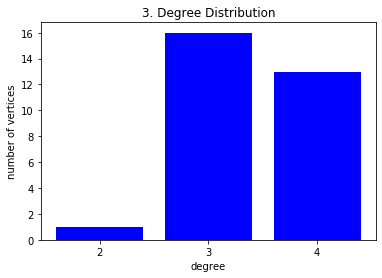

In [15]:
# 그래프의 차수 분포을 그리는 부분입니다.
degree_sequence = sorted([d for n, d in random_graph.degree()], reverse = True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.bar(deg, cnt, color="b")
plt.title("3. Degree Distribution")
plt.xlabel('degree')
plt.ylabel('number of vertices')
plt.xticks([2, 3, 4])
plt.show()